In [1]:
import pandas as pd

In [2]:
avg_loan_amount = 8000
avg_rate = 0.18
# 3 cases, all are pretty highh considering the type of loans these are
lgd_scenarios = {
    'Good': 0.5,    
    'Medium': 0.7,  
    'Bad': 0.9    
}


In [8]:
models = {
'Log Reg': {'TP': 2600, 'FP': 5213, 'TN': 14340, 'FN': 808},
'Random Forest': {'TP': 2286, 'FP': 3847, 'TN': 15706, 'FN': 1122},
'XGboost': {'TP': 2528,  'FP': 4190, 'TN': 15363, 'FN': 880},
'NN': {'TP': 1928,  'FP': 2604, 'TN': 16949, 'FN': 1480},
}

In [9]:
for name, metrics in models.items():
    total = metrics['TP'] + metrics['FP'] + metrics['TN'] + metrics['FN']
    print(f"{name}: Total observations = {total}")

Log Reg: Total observations = 22961
Random Forest: Total observations = 22961
XGboost: Total observations = 22961
NN: Total observations = 22961


In [10]:
results = []

for name, cm in models.items():
    TN_profit = cm['TN'] * avg_loan_amount * avg_rate  # Profit from correctly approved loans
    missed_profit = cm['FP'] * avg_loan_amount * avg_rate   # Loss from rejecting good clients
    
    net_earnings = {}
    for scenario, lgd in lgd_scenarios.items():
        FN_loss = cm['FN'] * avg_loan_amount * lgd  # Losses from defaults
        net_earning = TN_profit - FN_loss - missed_profit
        net_earnings[f'Net Earnings ({scenario})'] = net_earning
    
    results.append({
        'Model': name,
        **net_earnings  # Unpack scenario-specific net earnings
    })

df = pd.DataFrame(results)

# Sort by Medium scenario 
df.sort_values(by='Net Earnings (Medium)', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

# Format all monetary values
money_cols = [col for col in df.columns if 'Net Earnings' in col]
df[money_cols] = df[money_cols].applymap(lambda x: f'${x:,.0f}')

C:\Users\antek\AppData\Local\Temp\ipykernel_17596\3198950943.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[money_cols] = df[money_cols].applymap(lambda x: f'${x:,.0f}')


In [11]:
df

,Model,Net Earnings (Good),Net Earnings (Medium),Net Earnings (Bad)
0,NN,"$14,736,800","$12,368,800","$10,000,800"
1,XGboost,"$12,569,120","$11,161,120","$9,753,120"
2,Random Forest,"$12,588,960","$10,793,760","$8,998,560"
3,Log Reg,"$9,910,880","$8,618,080","$7,325,280"


<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
C:\Users\antek\AppData\Local\Temp\ipykernel_17596\60292218.py:8: SyntaxWarning: invalid escape sequence '\$'
  plot_df[col] = plot_df[col].replace('[\$,]', '', regex=True).astype(float)


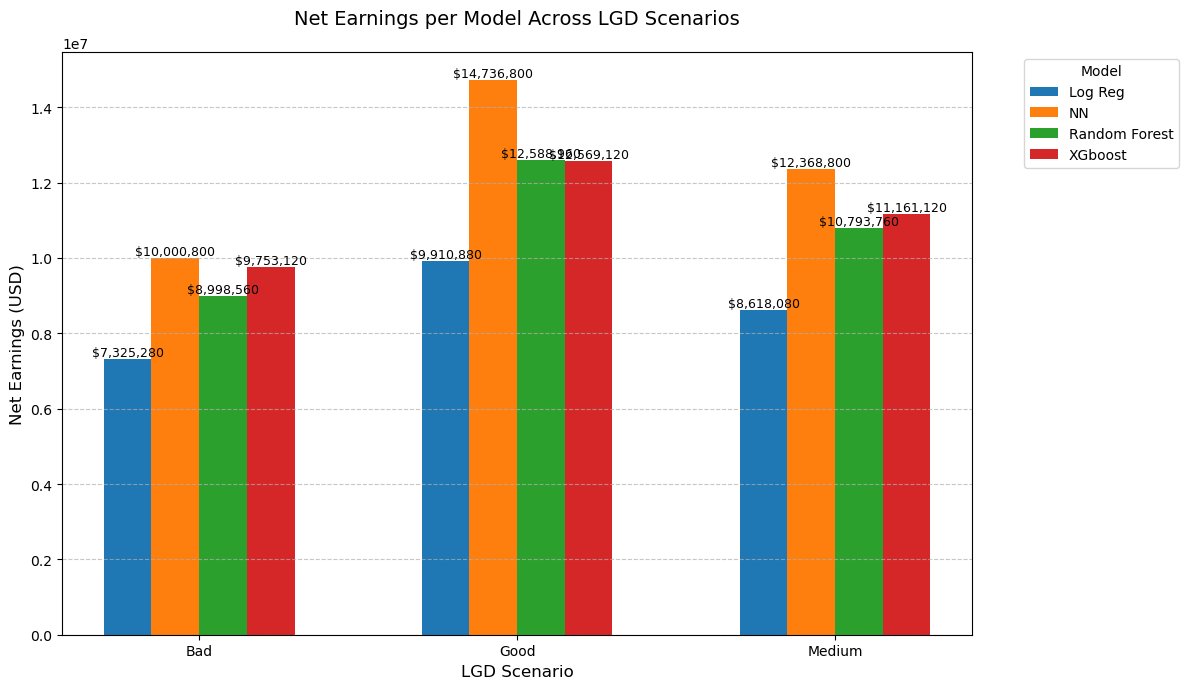

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# convert back to numericals
plot_df = df.copy()
for col in money_cols:
    plot_df[col] = plot_df[col].replace('[\$,]', '', regex=True).astype(float)


melted_df = plot_df.melt(id_vars='Model', value_vars=money_cols,
                         var_name='Scenario', value_name='Net Earnings')


melted_df['Scenario'] = melted_df['Scenario'].str.extract(r'Net Earnings \((.+)\)')

# Pivot the data to have scenarios on the x-axis and models as bars
pivot_df = melted_df.pivot(index='Scenario', columns='Model', values='Net Earnings')

# Plotting
x = np.arange(len(pivot_df.index))  # positions for each scenario
bar_width = 0.15
models = pivot_df.columns
offsets = np.linspace(-bar_width * (len(models) - 1) / 2, bar_width * (len(models) - 1) / 2, len(models))

plt.figure(figsize=(12, 7))

for i, model in enumerate(models):
    bars = plt.bar(x + offsets[i], pivot_df[model], width=bar_width, label=model)
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'${height:,.0f}',
                 ha='center', va='bottom', fontsize=9)

# Final touches
plt.xticks(ticks=x, labels=pivot_df.index)
plt.xlabel('LGD Scenario', fontsize=12)
plt.ylabel('Net Earnings (USD)', fontsize=12)
plt.title('Net Earnings per Model Across LGD Scenarios', fontsize=14, pad=20)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('net_earnings_bar_chart.png', dpi=300)
plt.show()